# Restaurant Sentiment Analysis
Dataset of 10,000 reviews across 100 restaurants from kaggle:
https://www.kaggle.com/datasets/joebeachcapital/restaurant-reviews?resource=download
Can we predict the sentiment from the review text
We will make this a classification task and adapt the target from a star review to a positive/negative review

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string

# Scikit-learn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Tensorflow-Keras libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# NLTK
from nltk.corpus import stopwords


2024-02-20 22:30:47.563230: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 22:30:47.611467: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 22:30:47.612095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 22:30:48.587267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## First explore the dataset

In [2]:
df = pd.read_csv('./data/Restaurant reviews.csv', dtype=str)

In [3]:
display(df.head())
print(df.shape)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


(10000, 8)


In [4]:
for colname in df.columns:
    print(colname)
    display(df[colname].value_counts(dropna=False))
    print()

Restaurant


Restaurant
Beyond Flavours                                      100
Dine O China                                         100
Driven Cafe                                          100
Labonel                                              100
Eat India Company                                    100
Urban Asia - Kitchen & Bar                           100
The Indi Grill                                       100
The Tilt Bar Republic                                100
Yum Yum Tree - The Arabian Food Court                100
Aromas@11SIX                                         100
Komatose - Holiday Inn Express & Suites              100
Hyderabad Chefs                                      100
Shree Santosh Dhaba Family Restaurant                100
Paradise                                             100
Prism Club & Kitchen                                 100
PourHouse7                                           100
KS Bakers                                            100
Tempteys            


Reviewer


Reviewer
NaN                 38
Ankita              13
Parijat Ray         13
Kiran               12
Jay Mehta           11
                    ..
Anjana Dandekar      1
Shailesh Agarwal     1
Vinaya Chekuri       1
Sonal Ambani         1
Bhargava Krishna     1
Name: count, Length: 7447, dtype: int64


Review


Review
good                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       237
Good                                                                                                                                                                                                                                                                                                                                                                                                                                                                              


Rating


Rating
5       3832
4       2373
1       1735
3       1193
2        684
4.5       69
3.5       47
NaN       38
2.5       19
1.5        9
Like       1
Name: count, dtype: int64


Metadata


Metadata
1 Review                        919
1 Review , 1 Follower           750
2 Reviews , 1 Follower          337
2 Reviews                       262
1 Review , 2 Followers          227
                               ... 
22 Reviews , 22 Followers         1
14 Reviews , 94 Followers         1
32 Reviews , 1445 Followers       1
33 Reviews , 8 Followers          1
472 Reviews , 1302 Followers      1
Name: count, Length: 2478, dtype: int64


Time


Time
NaN                38
5/14/2019 23:44     3
7/29/2018 20:34     3
5/24/2019 21:17     3
7/6/2018 23:15      3
                   ..
2/17/2019 20:19     1
2/15/2019 18:59     1
2/15/2019 15:57     1
2/15/2019 15:39     1
5/31/2016 16:41     1
Name: count, Length: 9783, dtype: int64


Pictures


Pictures
0     8016
1      707
2      383
3      246
4      129
5      116
7       86
6       85
8       55
9       47
10      35
15      12
12       9
11       9
14       7
13       6
20       5
17       4
19       4
27       4
21       4
18       4
22       4
16       4
24       3
26       2
42       2
28       2
25       2
34       2
52       1
41       1
37       1
64       1
23       1
32       1
Name: count, dtype: int64


7514


7514
NaN     9999
2447       1
Name: count, dtype: int64

Take a look at a few values of "Review" for each "Rating"

In [5]:
df.groupby('Rating').head(5).sort_values(by='Rating')

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
14,Beyond Flavours,Kankaria.ritu,"We ordered corn cheese balls, manchow soup and...",1,1 Review,5/22/2019 21:19,0,NaN
84,Beyond Flavours,Sreshta Ladegaam,This was my worst experience at a restaurant e...,1,"25 Reviews , 722 Followers",5/9/2019 12:37,0,NaN
80,Beyond Flavours,Surya Sharma,"Hostile staff, okeish food, not so great ambia...",1,"2 Reviews , 10 Followers",5/10/2019 23:24,0,NaN
79,Beyond Flavours,Vignesh Rk,I would like to introduce this restaurant to a...,1,"13 Reviews , 67 Followers",5/11/2019 10:06,6,NaN
66,Beyond Flavours,Tejaswi Rao,"we went for a team lunch, such a worst restaur...",1,"1 Review , 24 Followers",5/15/2019 3:26,0,NaN
9298,Collage - Hyatt Hyderabad Gachibowli,Rajiv Kurian,Went for Sunday brunch with a lots of expectat...,1.5,"23 Reviews , 13 Followers",6/16/2017 13:21,0,NaN
7244,Labonel,Shrav,the cake i bought started smelling bad the ver...,1.5,"4 Reviews , 39 Followers",12/30/2017 16:56,0,NaN
5994,KS Bakers,Aditya Arora,"I ordered mini veg pizza, manchuria, veg hot d...",1.5,"32 Reviews , 107 Followers",7/9/2017 19:29,0,NaN
5992,KS Bakers,Nishtha Chandarana,This bakery is located at very prime location ...,1.5,"151 Reviews , 2116 Followers",7/21/2017 18:29,0,NaN
5593,Cafe Eclat,Ananta Ray,Went to this place couple of weeks back. Wasnt...,1.5,"90 Reviews , 300 Followers",5/3/2018 11:44,0,NaN


Remove rows with NaN for rating as well as any duplicates

In [6]:
df.dropna(axis=0, subset=['Rating', 'Review'], inplace=True)
df.drop_duplicates()
print(df.shape)

(9955, 8)


Choose to to have values 4-5 as positive sentiment (which we set to one) and <= 3 as negative sentiment (which we set to 0)

/tmp/ipykernel_2216/2685573048.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentiment', palette=['red',"green"])


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

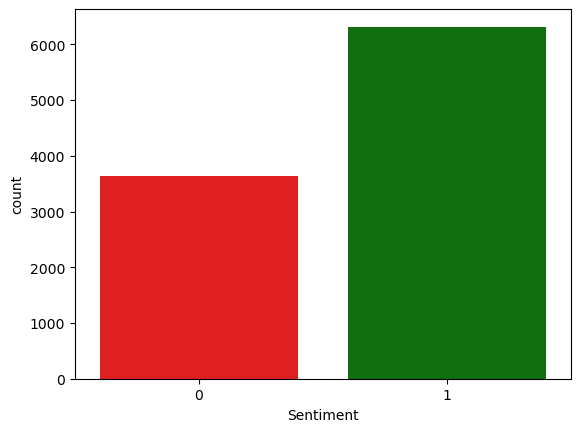

In [7]:
def rating_to_sentiment(rating, cut_off: float = 3.0):
    
    """Convert rating to sentiment based on cut-off value"""
    
    if rating == 'Like':
        return 1
    elif float(rating) > cut_off:
        return 1
    elif float(rating) <= cut_off:
        return 0
    else:
        return None


df['Sentiment'] = df['Rating'].apply(lambda x: rating_to_sentiment(x, 3.0))
df['Sentiment'].value_counts(dropna=False)
sns.countplot(data=df, x='Sentiment', palette=['red',"green"])

See if length of review relates to sentiment

In [8]:
df['Review_length'] = df['Review'].str.len()

In [9]:
df['Review_length'].value_counts(dropna=False)

Review_length
4       341
140     108
9       103
141      94
146      92
       ... 
1588      1
1166      1
1071      1
923       1
1555      1
Name: count, Length: 1167, dtype: int64

In [10]:
df.groupby('Sentiment').agg({
    'Review_length': ['mean', 'std']})

Review_length            
                   mean         std
Sentiment                          
0            282.587524  306.487861
1            278.153737  355.799677

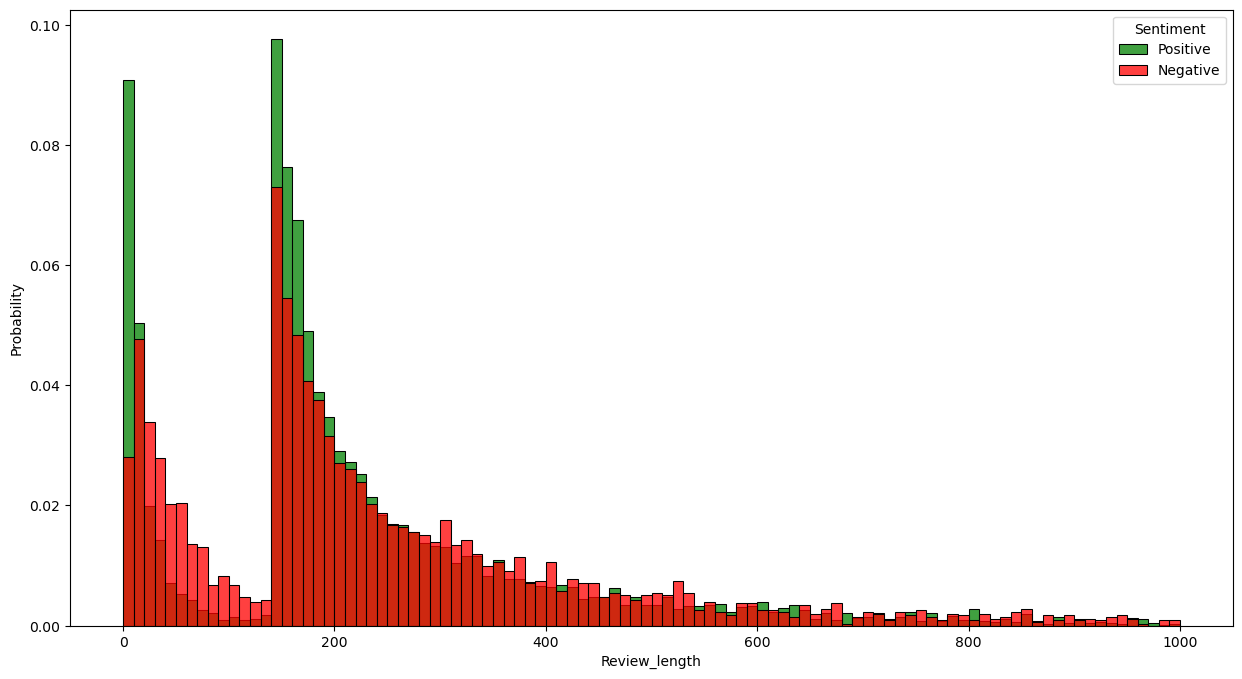

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
df_positive = df[df['Sentiment']==1]
df_negative = df[df['Sentiment']==0]

sns.histplot(df_positive, x=df_positive['Review_length'], stat='probability',  binwidth=10, binrange=(0, 1000), ax=ax, color='g', label='Positive')
sns.histplot(df_negative, x=df_negative['Review_length'], stat='probability', binwidth=10, binrange=(0, 1000), ax=ax, color='r', label='Negative')
plt.legend(title='Sentiment')

In [12]:
df.groupby('Restaurant').agg({
    'Review_length': ['count', 'max', 'mean']
})

Review_length        \
                                                          count   max   
Restaurant                                                              
10 Downing Street                                           100  1562   
13 Dhaba                                                    100   950   
3B's - Buddies, Bar & Barbecue                              100  1426   
AB's - Absolute Barbecues                                   100  1061   
Absolute Sizzlers                                           100   942   
Al Saba Restaurant                                           99  1033   
American Wild Wings                                          77  2736   
Amul                                                         99   680   
Arena Eleven                                                 85  4119   
Aromas@11SIX                                                100  2437   
Asian Meal Box                                              100   842   
B-Dubs                                                      100   735   
Banana Leaf Multicuisine Restaurant                         100  2632   
Barbeque Nation                                             100  1443   
Behrouz Biryani                                             100  1048   
Being Hungry                                                 99   594   
Beyond Flavours                                             100  1781   
Biryanis And More                                           100  4610   
Cafe Eclat                                                  100  1441   
Cascade - Radisson Hyderabad Hitec City                     100  3462   
Chinese Pavilion                                            100  2088   
Club Rogue                                                  100  2900   
Collage - Hyatt Hyderabad Gachibowli                        100  2144   
Cream Stone                                                 100  1257   
Delhi-39                                                    100   457   
Deli 9 Bistro                                               100   925   
Desi Bytes                                                  100   926   
Dine O China                                                100  2651   
Diners Pavilion                                             100  1980   
Domino's Pizza                                               99  1105   
Driven Cafe                                                 100  2014   
Dunkin' Donuts                                              100  1726   
Eat India Company                                           100  1822   
Faasos                                                      100  1134   
Feast - Sheraton Hyderabad Hotel                            100  1344   
Flechazo                                                    100  1739   
Frio Bistro                                                 100  1833   
GD's                                                        100  1355   
Gal Punjab Di                                               100  1588   
Green Bawarchi Restaurant                                   100   755   
Hitech Bawarchi Food Zone                                   100   724   
Hotel Zara Hi-Fi                                            100   519   
Hunger Maggi Point                                          100   919   
Hyderabad Chefs                                              98   485   
Hyderabadi Daawat                                           100  5212   
Hyper Local                                                 100  4104   
Jonathan's Kitchen - Holiday Inn Express & Suites           100  5172   
KFC                                                         100   820   
KS Bakers                                                   100   875   
Karachi Bakery                                              100   851   
Karachi Cafe                                                100  1663   
Khaan Saab                                                  100  1767   
Komatose - Holiday Inn Express & Su

## Machine Learning with Simple Models

### Count Vectoriser with Random Forest

In [13]:
X = df[['Review', 'Review_length']]
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [14]:
# Set up pipeline to which involves a CountVectoriser (bag of words with counts) and random forest

text_pipeline = Pipeline([
    ('countvectorize', CountVectorizer()), # integer counts of words
])

numeric_pipeline = Pipeline([
    ('scaler', StandardScaler()) # scales values to have mean of 0 and std of 1
])

In [15]:
full_pipeline = ColumnTransformer(transformers=[
    ('text', text_pipeline, 'Review'), # must be 1D array passed to text_pipleline
    ('numeric', numeric_pipeline, ['Review_length'])
])

In [16]:
display(full_pipeline)

ColumnTransformer(transformers=[('text',
                                 Pipeline(steps=[('countvectorize',
                                                  CountVectorizer())]),
                                 'Review'),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Review_length'])])

In [17]:
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

# end result is that we each word has an id (a feature) and a count
# for each review, the last id is actually the standardised length of the review

In [18]:
print('Review 11:')
print(X_train[10])
print('\nReview 8:')
print(X_train[7])

Review 11:
  (0, 4499)	1.0
  (0, 4945)	1.0
  (0, 12256)	1.0
  (0, 12682)	-0.7772845221393366

Review 8:
  (0, 4075)	1.0
  (0, 12682)	-0.7889329719417504


Run a random forest classifier

In [19]:
random_forest_classfier = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest_classfier.fit(X_train, y_train)
y_test_preds = random_forest_classfier.predict(X_test)

In [20]:
print(confusion_matrix(y_test, y_test_preds))
print(classification_report(y_test, y_test_preds))

[[ 846  250]
 [  85 1806]]
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      1096
           1       0.88      0.96      0.92      1891

    accuracy                           0.89      2987
   macro avg       0.89      0.86      0.87      2987
weighted avg       0.89      0.89      0.89      2987



### Count Vectoriser (removing stopwords) and Random Forest

In [21]:
X = df[['Review', 'Review_length']]
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


In [22]:
def text_process(review):
    
    # check chars to see if in punctuation
    nopunc = [char for char in review if char not in string.punctuation]
    
    # retransform list of chars back into list of words
    words = ''.join(nopunc)
    
    # remove stopwords
    return [word for word in words.split() if word.lower() not in stopwords.words('english')]


In [23]:
# Set up pipeline to which involves a CountVectoriser (bag of words with counts) and random forest

text_pipeline = Pipeline([
    ('countvectorize', CountVectorizer(analyzer=text_process)), # integer counts of words
])

numeric_pipeline = Pipeline([
    ('scaler', StandardScaler()) # scales values to have mean of 0 and std of 1
])

In [24]:
full_pipeline = ColumnTransformer(transformers=[
    ('text', text_pipeline, 'Review'), # must be 1D array passed to text_pipleline
    ('numeric', numeric_pipeline, ['Review_length'])
])

In [25]:
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

In [26]:
random_forest_classfier = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest_classfier.fit(X_train, y_train)
y_test_preds = random_forest_classfier.predict(X_test)

In [27]:
print(confusion_matrix(y_test, y_test_preds))
print(classification_report(y_test, y_test_preds))

[[ 788  308]
 [ 120 1771]]
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      1096
           1       0.85      0.94      0.89      1891

    accuracy                           0.86      2987
   macro avg       0.86      0.83      0.84      2987
weighted avg       0.86      0.86      0.85      2987



### Count Vectoriser (removing stopwords), TF-IDF and Random Forest

In [28]:
X = df[['Review', 'Review_length']]
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [29]:
# Set up pipeline to which involves a CountVectoriser (bag of words with counts) and random forest

text_pipeline = Pipeline([
    ('countvectorize', CountVectorizer(analyzer=text_process)), # integer counts of words
    ('tfidf', TfidfTransformer()),
])

numeric_pipeline = Pipeline([
    ('scaler', StandardScaler()) # scales values to have mean of 0 and std of 1
])

In [30]:
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

In [31]:
random_forest_classfier = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest_classfier.fit(X_train, y_train)
y_test_preds = random_forest_classfier.predict(X_test)

In [32]:
print(confusion_matrix(y_test, y_test_preds))
print(classification_report(y_test, y_test_preds))

[[ 788  308]
 [ 120 1771]]
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      1096
           1       0.85      0.94      0.89      1891

    accuracy                           0.86      2987
   macro avg       0.86      0.83      0.84      2987
weighted avg       0.86      0.86      0.85      2987



### Try a simple RNN
This is a pre-cursor to the transformers that are part of LLMs

In [33]:
X = df[['Review', 'Review_length']]
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [34]:
def text_process_nns(X_review: pd.Series):
    #X_review_processed = X_review.str[:300] # first 300 characters should be enough oto gather sentiment - speeds up training
    X_review_processed = X_review.str.replace("<br\\s*/?>", " ", regex=True) # replace "<br /> tags with spaces
    X_review_processed = X_review_processed.str.replace("[^A-Za-z]", " ", regex=True) # remove character others than letters and quotes with spaces
    X_review_processed = X_review_processed.str.replace("\\s+", " ", regex=True) # replace more than one space with just one space
    X_review_processed = X_review_processed.str.lower()
    
    return X_review_processed

In [35]:
X_train_review = X_train['Review']
X_train_review = text_process_nns(X_train_review)

X_test_review = X_test['Review']
X_test_review = text_process_nns(X_test_review)

In [36]:
X_train_review

5300    a classy restaurant in gachibowli area that se...
1454    i felt this is somewhat bigger compared to jub...
8009    ordered the chicken tandoori biriyani few days...
5715    the food was absolutely wonderful from prepara...
7862    woooow i found a place with great food and exc...
                              ...                        
599     a place with great ambience and good food here...
5696    have visited this place couple of times and as...
8011    hi team i am big fan of your restaurant and i ...
1361    the ambience is very nice the place has both i...
1547    there should be pieces of hot n crispy but i g...
Name: Review, Length: 6968, dtype: object

In [37]:
VOCAB_SIZE = 10000
MAX_WORDS_PER_REVIEW = 60
EMBED_SIZE = 128

In [38]:
# Tokenize the words so each word has a numeric ID

# fit on training data
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<oov>')
tokenizer.fit_on_texts(X_train_review)

# transform on training and test data
X_train_review_sequences = tokenizer.texts_to_sequences(X_train_review)
X_test_review_sequences = tokenizer.texts_to_sequences(X_test_review)

In [39]:
print('Review 1 tokenized:')
print(X_train_review_sequences[0])

print('\nReview 2 tokenized:')
print(X_train_review_sequences[1])

print('\nLength of training sample =', len(X_train_review_sequences))

Review 1 tokenized:
[6, 1166, 65, 16, 185, 273, 31, 576, 276, 80, 454, 13, 45, 6, 19, 6655, 150, 2, 443, 27, 240, 3, 2373, 163, 171, 781, 26, 24, 32, 5, 253, 2, 13, 81, 5, 587]

Review 2 tokenized:
[8, 309, 17, 7, 2018, 1919, 448, 5, 5037, 1009, 695, 22, 42, 2, 6656, 7, 1677, 15, 117, 122, 125, 41, 714, 65, 66, 47, 310, 55, 433, 228, 5, 2, 33, 724, 6657, 1340, 7, 225, 180, 16, 33, 3, 399, 9, 129, 17, 49, 51, 165, 552, 3, 306, 2, 13, 5, 2752]

Length of training sample = 6968


In [40]:
# pad the arrays so all have the same length (100 words likely to be enough to determine review)
# the padding will take place at the end of the sentence
X_train_review_sequences_padded = pad_sequences(X_train_review_sequences, maxlen=MAX_WORDS_PER_REVIEW, padding='post', truncating='post')
X_test_review_sequences_padded = pad_sequences(X_test_review_sequences, maxlen=MAX_WORDS_PER_REVIEW, padding='post', truncating='post')

In [41]:
print('Review 1 tokenized and padded:')
print(X_train_review_sequences_padded[0])

print('\nReview 2 tokenized and padded:')
print(X_train_review_sequences_padded[1])

print('\nLength of training sample =', len(X_train_review_sequences_padded))

Review 1 tokenized and padded:
[   6 1166   65   16  185  273   31  576  276   80  454   13   45    6
   19 6655  150    2  443   27  240    3 2373  163  171  781   26   24
   32    5  253    2   13   81    5  587    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]

Review 2 tokenized and padded:
[   8  309   17    7 2018 1919  448    5 5037 1009  695   22   42    2
 6656    7 1677   15  117  122  125   41  714   65   66   47  310   55
  433  228    5    2   33  724 6657 1340    7  225  180   16   33    3
  399    9  129   17   49   51  165  552    3  306    2   13    5 2752
    0    0    0    0]

Length of training sample = 6968


In [42]:
# Try a simple RNN first of all

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBED_SIZE, input_length=MAX_WORDS_PER_REVIEW),
    SimpleRNN(EMBED_SIZE, input_length=[None, 1]),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = model.fit(X_train_review_sequences_padded, y_train, epochs=5)

Epoch 1/5
218/218 [==============================] - 8s 31ms/step - loss: 0.6686 - accuracy: 0.6072 - precision: 0.6464 - recall: 0.8423
Epoch 2/5
218/218 [==============================] - 7s 31ms/step - loss: 0.6300 - accuracy: 0.6536 - precision: 0.6813 - recall: 0.8540
Epoch 3/5
218/218 [==============================] - 7s 32ms/step - loss: 0.6135 - accuracy: 0.6749 - precision: 0.6950 - recall: 0.8698
Epoch 4/5
218/218 [==============================] - 7s 32ms/step - loss: 0.5560 - accuracy: 0.7331 - precision: 0.7482 - recall: 0.8737
Epoch 5/5
218/218 [==============================] - 7s 31ms/step - loss: 0.4939 - accuracy: 0.7768 - precision: 0.7959 - recall: 0.8723


In [43]:
y_test_preds = model.predict(X_test_review_sequences_padded)
y_test_preds = y_test_preds.reshape(-1)
y_test_preds

94/94 [==============================] - 1s 4ms/step


array([0.8712691 , 0.53765   , 0.79243416, ..., 0.7956128 , 0.19845185,
       0.85458434], dtype=float32)

In [44]:
y_test_preds = np.where(y_test_preds>0.5, 1, 0)
y_test_preds

array([1, 1, 1, ..., 1, 0, 1])

In [45]:
print(confusion_matrix(y_test, y_test_preds))
print(classification_report(y_test, y_test_preds))

[[ 588  508]
 [ 264 1627]]
              precision    recall  f1-score   support

           0       0.69      0.54      0.60      1096
           1       0.76      0.86      0.81      1891

    accuracy                           0.74      2987
   macro avg       0.73      0.70      0.71      2987
weighted avg       0.74      0.74      0.73      2987



This does less well than our random forest earlier

### Try a more complex model using 2 connected LSTM cells

In [51]:
# Try a simple RNN first of all

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBED_SIZE, input_length=MAX_WORDS_PER_REVIEW),
    LSTM(EMBED_SIZE, input_shape=[None, 1], return_sequences=True),
    LSTM(EMBED_SIZE,),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = model.fit(X_train_review_sequences_padded, y_train, epochs=5)

Epoch 1/5
218/218 [==============================] - 24s 95ms/step - loss: 0.5215 - accuracy: 0.7415 - precision_2: 0.7305 - recall_2: 0.9397
Epoch 2/5
218/218 [==============================] - 21s 97ms/step - loss: 0.2680 - accuracy: 0.9043 - precision_2: 0.9187 - recall_2: 0.9318
Epoch 3/5
218/218 [==============================] - 21s 97ms/step - loss: 0.1854 - accuracy: 0.9394 - precision_2: 0.9479 - recall_2: 0.9573
Epoch 4/5
218/218 [==============================] - 21s 94ms/step - loss: 0.1516 - accuracy: 0.9554 - precision_2: 0.9633 - recall_2: 0.9666
Epoch 5/5
218/218 [==============================] - 21s 95ms/step - loss: 0.1135 - accuracy: 0.9666 - precision_2: 0.9738 - recall_2: 0.9736


In [52]:
y_test_preds = model.predict(X_test_review_sequences_padded)
y_test_preds = y_test_preds.reshape(-1)
y_test_preds

94/94 [==============================] - 4s 32ms/step


array([0.99259645, 0.08651932, 0.94876903, ..., 0.9790691 , 0.02482705,
       0.9915786 ], dtype=float32)

In [53]:
y_test_preds = np.where(y_test_preds>0.5, 1, 0)
y_test_preds

array([1, 0, 1, ..., 1, 0, 1])

In [54]:
print(confusion_matrix(y_test, y_test_preds))
print(classification_report(y_test, y_test_preds))

[[ 828  268]
 [ 128 1763]]
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1096
           1       0.87      0.93      0.90      1891

    accuracy                           0.87      2987
   macro avg       0.87      0.84      0.85      2987
weighted avg       0.87      0.87      0.87      2987



This does better but is still not as good as our random forest earlier

## Now try some Transformer LLMs

In [81]:
from skllm.config import SKLLMConfig

In [82]:
SKLLMConfig.set_openai_key(os.environ['OPEN_AI_KEY'])

### Try GPT - sadly this is not yet working!

In [83]:
from skllm import ZeroShotGPTClassifier

In [84]:
gpt_classifier_model = ZeroShotGPTClassifier(openai_model="gpt-3.5-turbo")

In [85]:
X = df[['Review', 'Review_length']]
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [86]:
X_train_review = X_train['Review']
X_test_review = X_test['Review']

In [ ]:
gpt_classifier_model.fit(X_train_review, y_train)
y_test_preds = gpt_classifier_model.predict(X_test_review)

In [ ]:
y_test_preds = np.where(y_test_preds>0.5, 1, 0)
y_test_preds

In [ ]:
print(confusion_matrix(y_test, y_test_preds))
print(classification_report(y_test, y_test_preds))

### Try a pre-trained word embedding

In [78]:
import tensorflow_hub as hub

model = Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = model.fit(X_train_review, y_train, epochs=5)

Epoch 1/5
218/218 [==============================] - 2s 3ms/step - loss: 0.4795 - accuracy: 0.7732 - precision_25: 0.7672 - recall_25: 0.9229
Epoch 2/5
218/218 [==============================] - 1s 3ms/step - loss: 0.3752 - accuracy: 0.8401 - precision_25: 0.8575 - recall_25: 0.8974
Epoch 3/5
218/218 [==============================] - 1s 3ms/step - loss: 0.3632 - accuracy: 0.8441 - precision_25: 0.8627 - recall_25: 0.8974
Epoch 4/5
218/218 [==============================] - 1s 3ms/step - loss: 0.3562 - accuracy: 0.8493 - precision_25: 0.8679 - recall_25: 0.8997
Epoch 5/5
218/218 [==============================] - 1s 2ms/step - loss: 0.3505 - accuracy: 0.8538 - precision_25: 0.8735 - recall_25: 0.9001


In [80]:
y_test_preds = model.predict(X_test_review)
y_test_preds = y_test_preds.reshape(-1)
y_test_preds

y_test_preds = np.where(y_test_preds>0.5, 1, 0)
y_test_preds

print(confusion_matrix(y_test, y_test_preds))
print(classification_report(y_test, y_test_preds))

94/94 [==============================] - 0s 2ms/step
[[ 818  278]
 [ 184 1707]]
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1096
           1       0.86      0.90      0.88      1891

    accuracy                           0.85      2987
   macro avg       0.84      0.82      0.83      2987
weighted avg       0.84      0.85      0.84      2987



### Try a transformer architecture

In [56]:
from TransformerArchitecture import TransformerBlock, TokenAndPositionEmbedding
import tensorflow.keras.layers as layers

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads

## Using Sequential API
model = Sequential([
    layers.Input(shape=(MAX_WORDS_PER_REVIEW, )),
    TokenAndPositionEmbedding(MAX_WORDS_PER_REVIEW, VOCAB_SIZE, embed_dim),
    TransformerBlock(embed_dim, num_heads, ff_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])


In [57]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(X_train_review_sequences_padded,
                    y_train,
                    epochs=5)

Epoch 1/5
218/218 [==============================] - 9s 31ms/step - loss: 0.4548 - accuracy: 0.7786 - precision_3: 0.7773 - recall_3: 0.9128
Epoch 2/5
218/218 [==============================] - 5s 25ms/step - loss: 0.2403 - accuracy: 0.9083 - precision_3: 0.9192 - recall_3: 0.9381
Epoch 3/5
218/218 [==============================] - 5s 25ms/step - loss: 0.1805 - accuracy: 0.9318 - precision_3: 0.9418 - recall_3: 0.9514
Epoch 4/5
218/218 [==============================] - 6s 29ms/step - loss: 0.1273 - accuracy: 0.9544 - precision_3: 0.9641 - recall_3: 0.9641
Epoch 5/5
218/218 [==============================] - 5s 23ms/step - loss: 0.0989 - accuracy: 0.9646 - precision_3: 0.9690 - recall_3: 0.9754


In [58]:
y_test_preds = model.predict(X_test_review_sequences_padded)
y_test_preds = y_test_preds.reshape(-1)
y_test_preds

y_test_preds = np.where(y_test_preds>0.5, 1, 0)
y_test_preds

print(confusion_matrix(y_test, y_test_preds))
print(classification_report(y_test, y_test_preds))

94/94 [==============================] - 1s 7ms/step
[[ 946  150]
 [ 274 1617]]
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1096
           1       0.92      0.86      0.88      1891

    accuracy                           0.86      2987
   macro avg       0.85      0.86      0.85      2987
weighted avg       0.86      0.86      0.86      2987



Both of these methods are quick and lead to accurate results